# **Imports**

In [1]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# common
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

# **Data**

In [4]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img

    return images

In [5]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [6]:
SIZE = 256

In [7]:
root_path = '/content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/Feature_img/mascaras'
classes = sorted(os.listdir(root_path))
classes

['figura4_frame_0_mask.png',
 'figura4_frame_0_mask1.png',
 'figura4_frame_0_mask2.png',
 'figura4_frame_100_mask.png',
 'figura4_frame_100_mask1.png',
 'figura4_frame_101_mask.png',
 'figura4_frame_101_mask1.png',
 'figura4_frame_101_mask2.png',
 'figura4_frame_102_mask.png',
 'figura4_frame_102_mask1.png',
 'figura4_frame_103_mask.png',
 'figura4_frame_103_mask1.png',
 'figura4_frame_104_mask.png',
 'figura4_frame_104_mask1.png',
 'figura4_frame_105_mask.png',
 'figura4_frame_105_mask1.png',
 'figura4_frame_106_mask.png',
 'figura4_frame_106_mask1.png',
 'figura4_frame_106_mask2.png',
 'figura4_frame_107_mask.png',
 'figura4_frame_107_mask1.png',
 'figura4_frame_108_mask.png',
 'figura4_frame_108_mask1.png',
 'figura4_frame_109_mask.png',
 'figura4_frame_109_mask1.png',
 'figura4_frame_10_mask.png',
 'figura4_frame_10_mask1.png',
 'figura4_frame_110_mask.png',
 'figura4_frame_110_mask1.png',
 'figura4_frame_111_mask.png',
 'figura4_frame_111_mask1.png',
 'figura4_frame_112_mask.png',

In [8]:
single_mask_paths = sorted(glob(root_path + "/*mask2.png"))

In [9]:
image_paths = []
mask_paths = []
for class_path in single_mask_paths:
      img_path = '/content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/Feature_img/capturas/' + os.path.basename(class_path.replace('_mask2',''))
      image_paths.append(img_path)
      mask_paths.append(class_path)

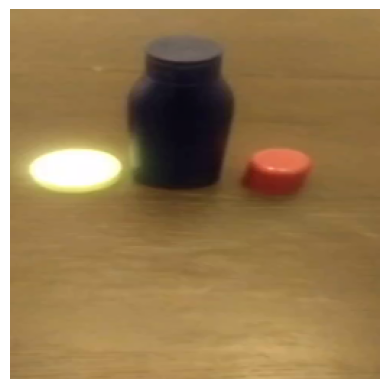

In [10]:
show_image(load_image(image_paths[0], SIZE))

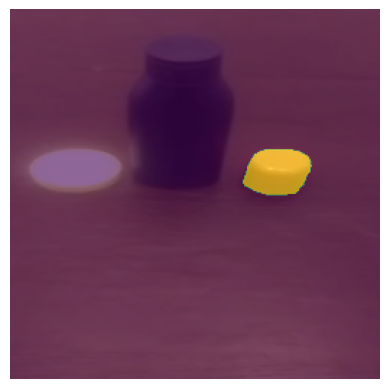

In [11]:
show_mask(load_image(image_paths[0], SIZE), load_image(mask_paths[0], SIZE)[:,:,0], alpha=0.6)

## **Data Work**

In [12]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

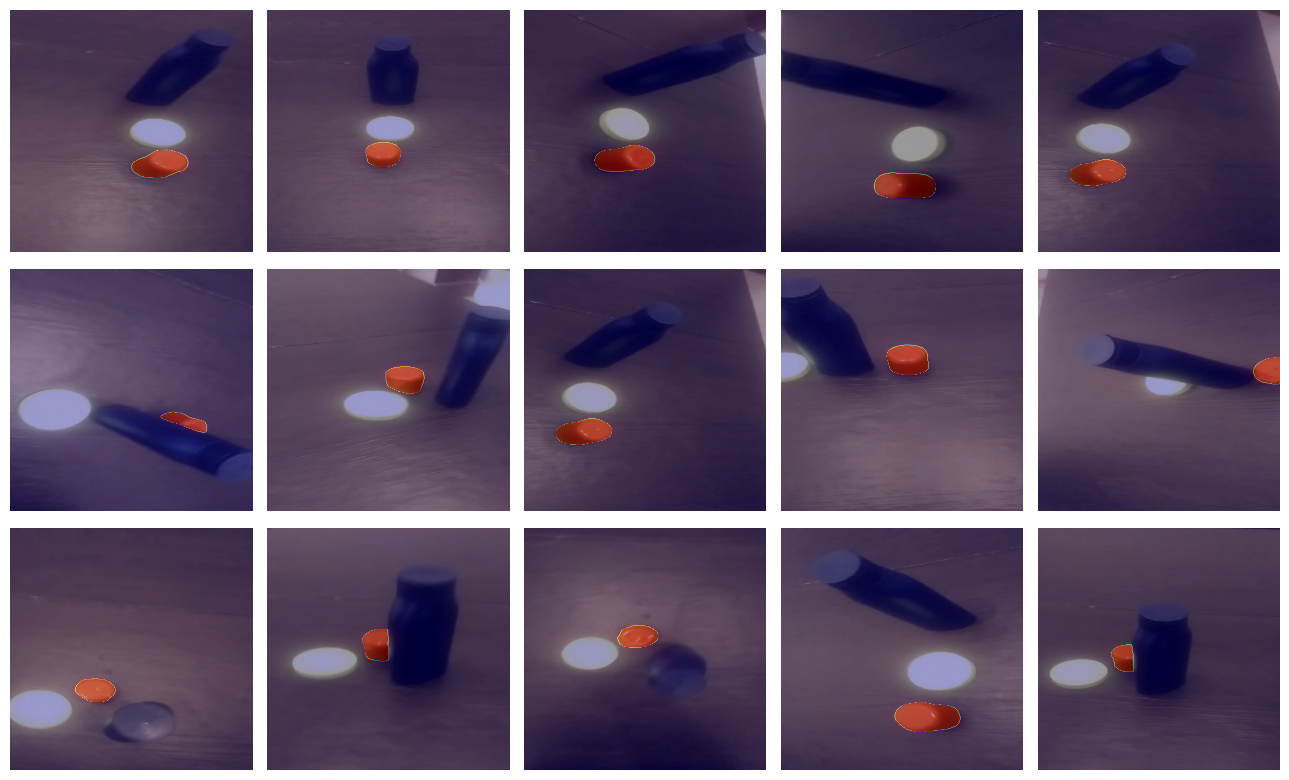

In [13]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

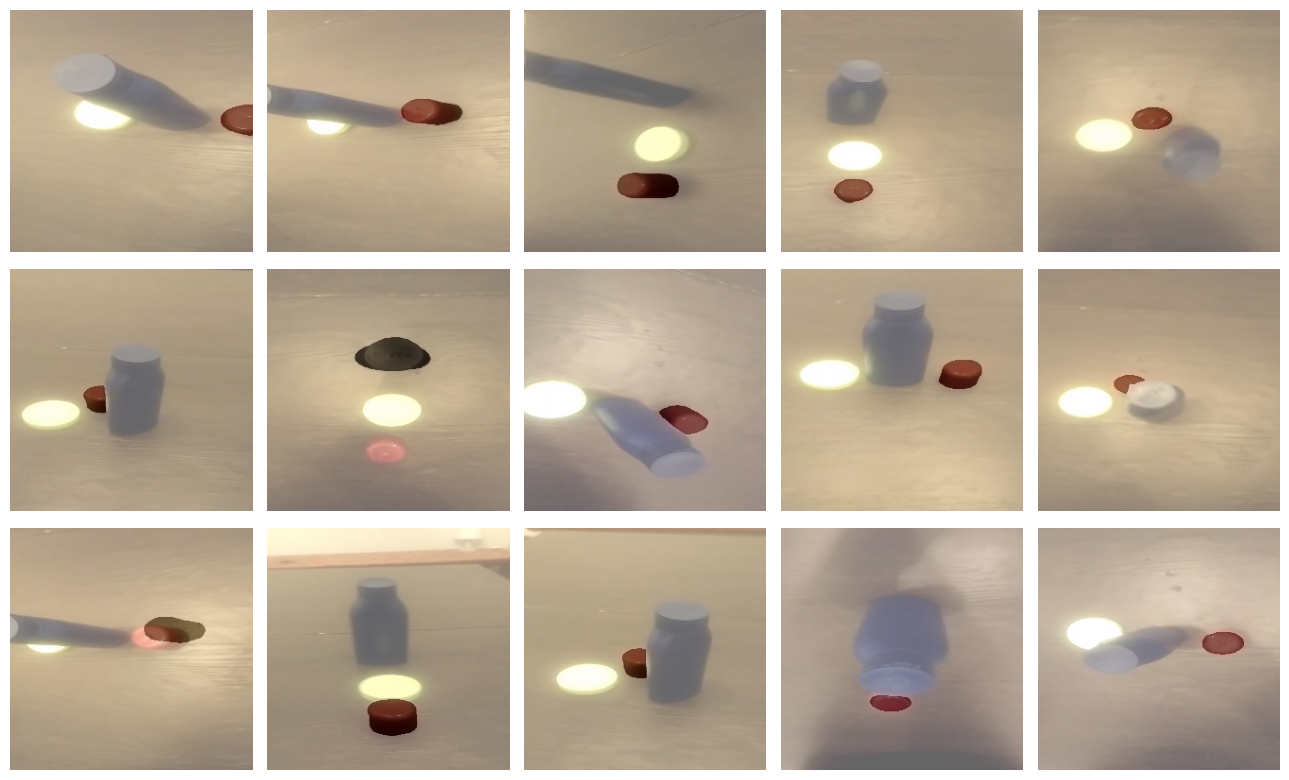

In [14]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='binary')
plt.tight_layout()
plt.show()

69
86
35
5
53
40
1
35
34
13
71
27
7
50
25


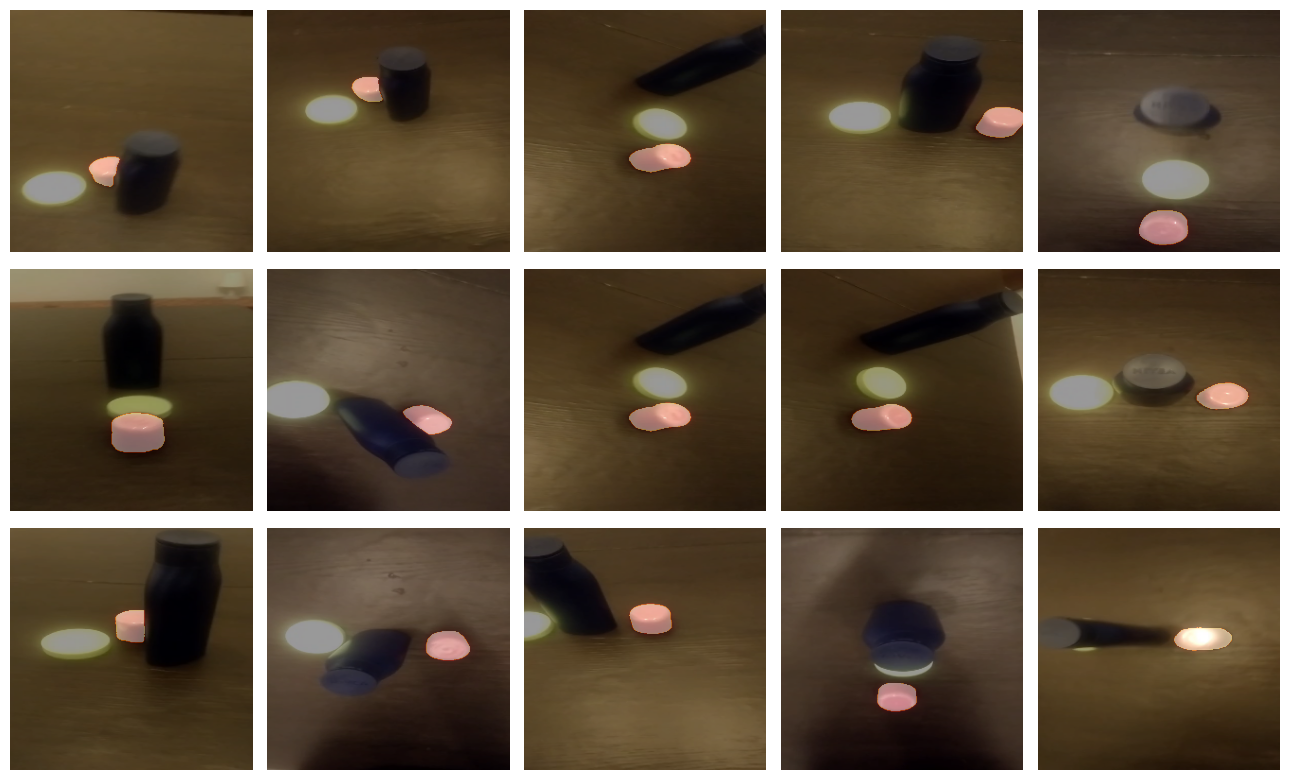

In [15]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='afmhot')
    print(id)
plt.tight_layout()
plt.show()

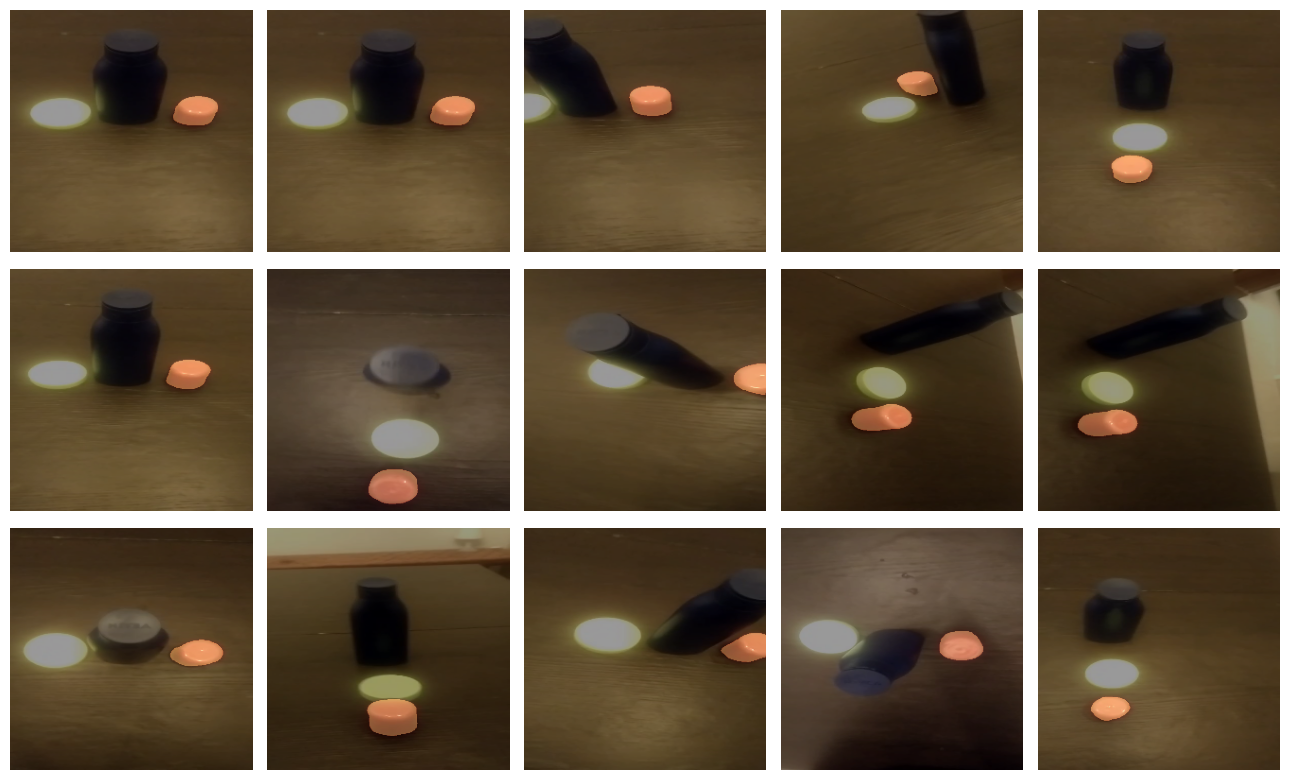

In [16]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

# **Encoder**

In [17]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

# **Decoder**

In [18]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

# **Attention Gate**

In [19]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

# **Custom Callback**

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import Callback

class ShowProgress(Callback):
    def __init__(self, images, masks):
        # Almacenamos las imágenes y las máscaras para mostrar durante el entrenamiento
        self.images = images
        self.masks = masks

    def on_epoch_end(self, epoch, logs=None):
        # Seleccionamos un índice aleatorio para visualizar
        index = np.random.randint(0, len(self.images))

        # Obtenemos la imagen original, la máscara objetivo y la predicción del modelo
        original_image = self.images[index]
        target_mask = self.masks[index]
        predicted_mask = self.model.predict(np.expand_dims(original_image, axis=0))[0]  # Accedemos a self.model

        # Visualizamos las tres imágenes: original, objetivo y predicción
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))

        # Imagen original
        ax[0].imshow(original_image.squeeze(), cmap='gray')
        ax[0].set_title('Imagen Original')
        ax[0].axis('off')

        # Máscara objetivo
        ax[1].imshow(target_mask.squeeze(), cmap='gray')
        ax[1].set_title('Máscara Objetivo')
        ax[1].axis('off')

        # Máscara predicha
        ax[2].imshow(predicted_mask.squeeze(), cmap='gray')
        ax[2].set_title('Máscara Predicción')
        ax[2].axis('off')

        # Mostramos las imágenes
        plt.show()


# **Attention UNet**

In [21]:
# Inputs
input_layer = Input(shape=images.shape[-3:])

# Encoder
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

# Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)

# Callbacks
cb = [
    ModelCheckpoint("/content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/ecografia-fase1 - Test/abdomenAttentionUNet.keras", save_best_only=True),
    ShowProgress(images=images, masks=masks)
]



/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'Encoding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'encoder_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'encoder_block_1', however the layer does n

# **Training**

In [22]:
# Config Training
BATCH_SIZE = 8

# Training
results = model.fit(
    images, masks,
    validation_split=0.2,
    epochs=150,
    batch_size=BATCH_SIZE,
    callbacks=cb
)


Output hidden; open in https://colab.research.google.com to view.

# **Evaluation**

In [23]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

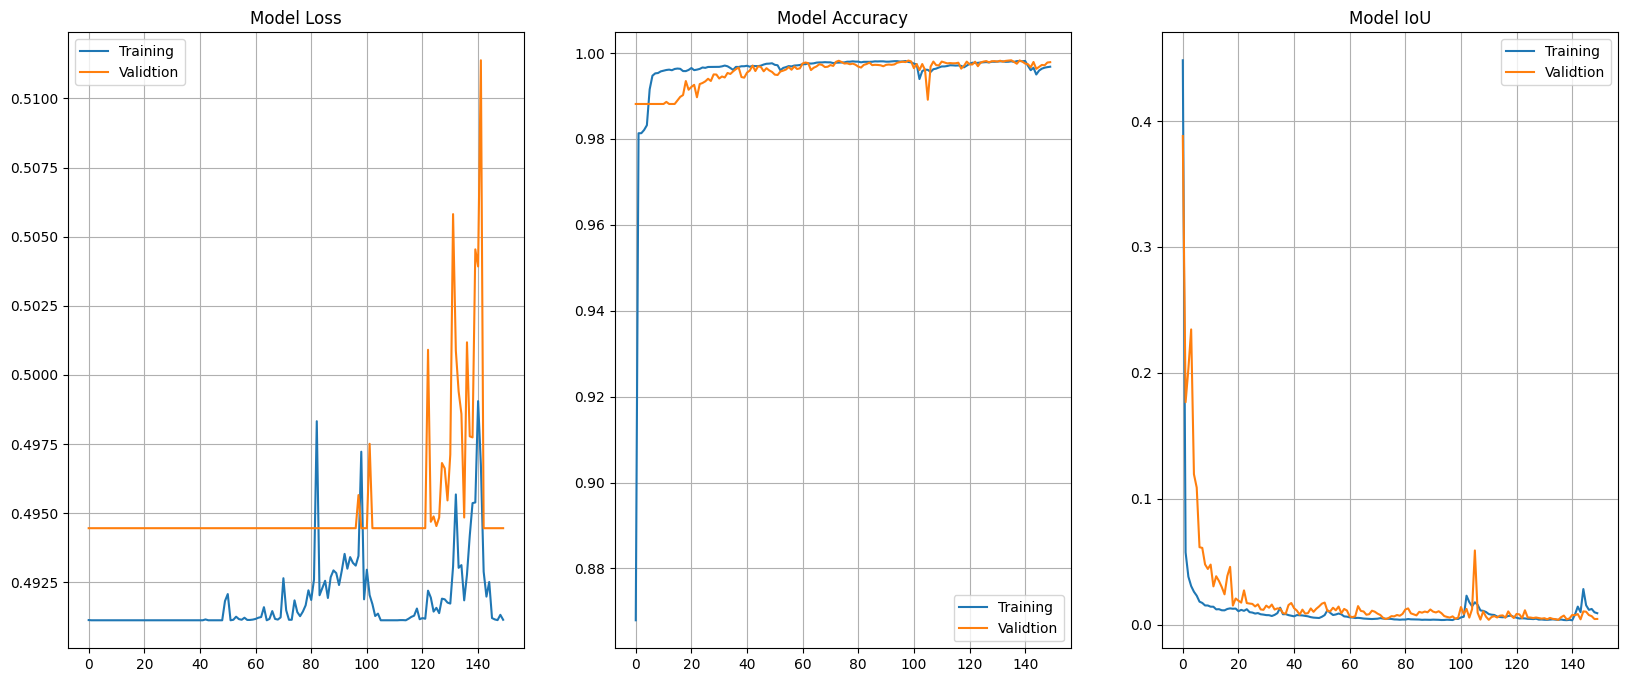

In [24]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


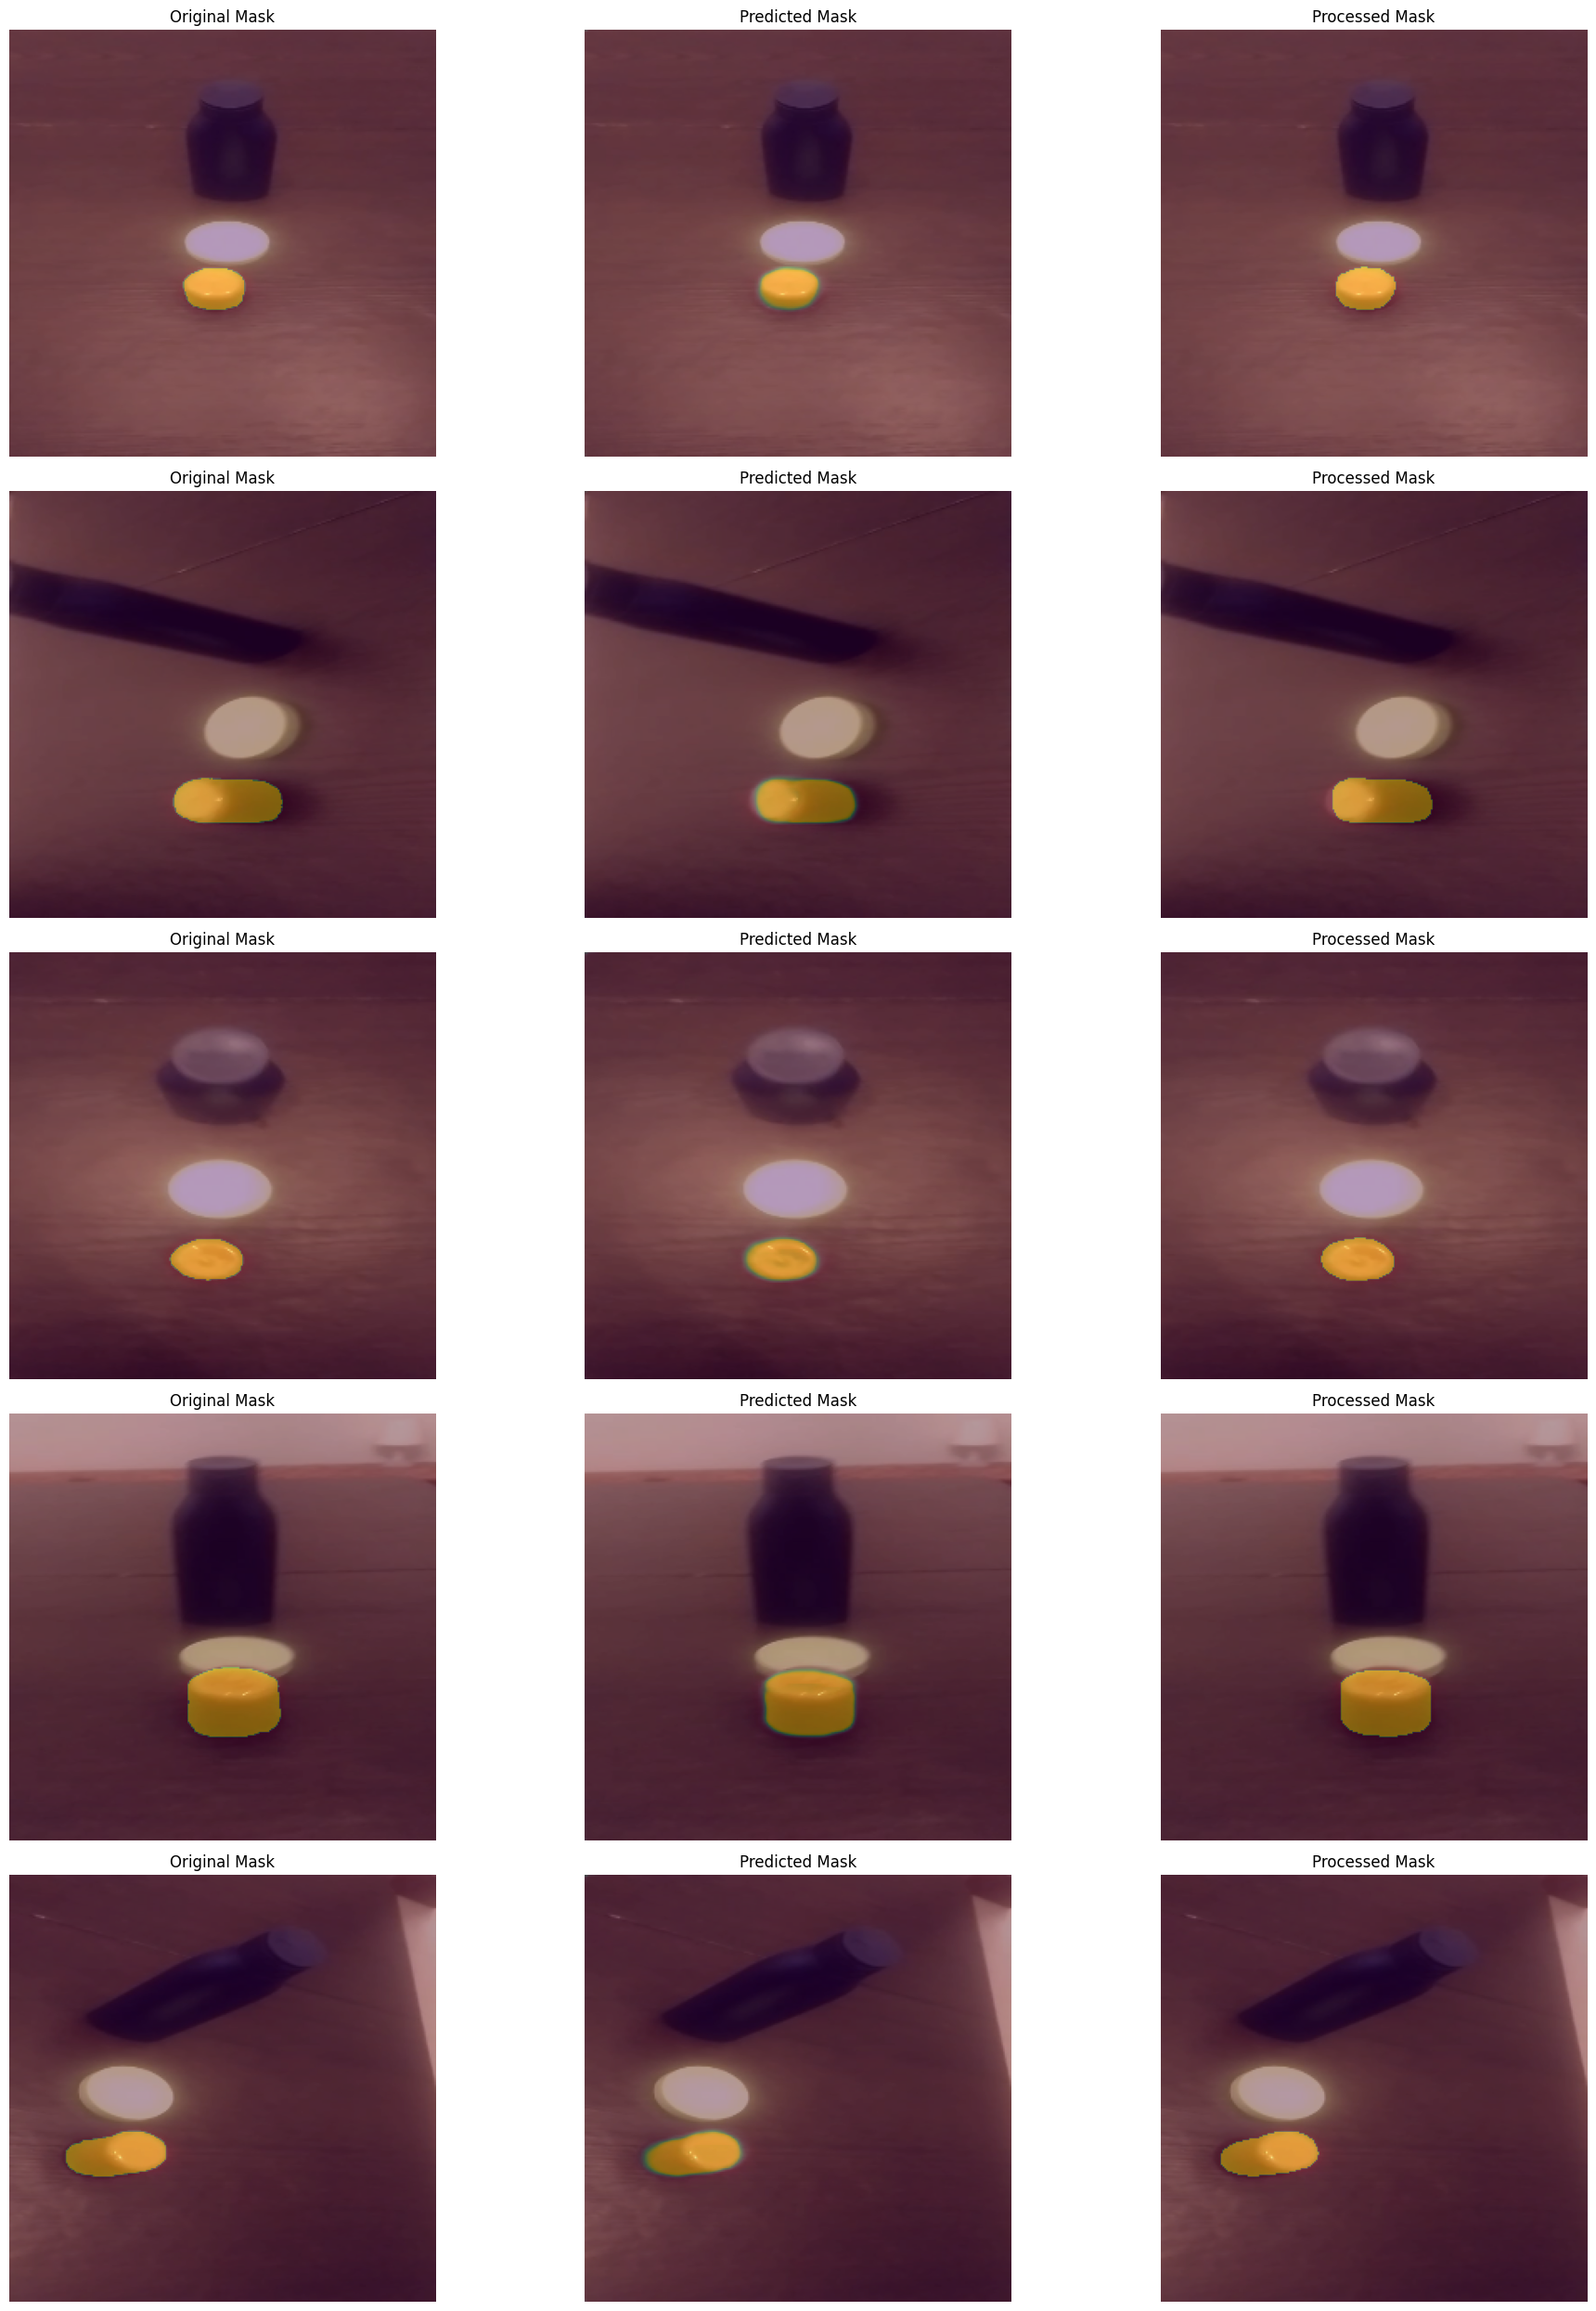

In [25]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

In [26]:
# Directorios de las capturas e imágenes
capturas_dir = '/content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/Feature_img/capturas/'  # Donde están las imágenes originales
mascaras_dir = '/content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/Feature_img/mascaras/'  # Donde están las máscaras generadas

# Obtener todas las imágenes en el directorio de capturas
all_images = glob(os.path.join(capturas_dir, '*.png'))  # Ajusta la extensión si es diferente

# Filtrar imágenes cuya máscara correspondiente no existe en el directorio de máscaras
images_without_masks = []
for img in all_images:
    # Obtener solo el nombre del archivo sin la extensión para comparar con la máscara
    img_filename = os.path.basename(img).replace('.png', '')

    # Ruta donde debería estar la máscara correspondiente
    mask_path = os.path.join(mascaras_dir, f"{img_filename}_mask2.png")

    # Si no existe la máscara, añadimos la imagen a la lista
    if not os.path.exists(mask_path):
        images_without_masks.append(img)

# Mostrar las imágenes que no tienen máscara generada
print(f"Total de imágenes sin máscara: {len(images_without_masks)}")

Total de imágenes sin máscara: 380


In [27]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import tensorflow as tf
import os

# Función para cargar y preprocesar la imagen
def load_image_for_prediction(image_path, SIZE):
    img = load_img(image_path, target_size=(SIZE, SIZE))
    img_array = img_to_array(img) / 255.0  # Normalizar la imagen
    img_array = np.expand_dims(img_array, axis=0)  # Añadir la dimensión de batch
    return img_array

# Función para guardar la máscara predicha
def save_predicted_mask(mask, output_path):
    # Asegurarnos de que la máscara tenga 3 dimensiones (256, 256, 1)
    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)  # Añadir el canal

    # Guardar la máscara predicha como imagen PNG
    tf.keras.preprocessing.image.save_img(output_path, mask, scale=True)

# Tamaño de entrada del modelo (ajusta esto si tu modelo usa otro tamaño)
SIZE = 256

# Procesar cada imagen sin máscara
for img_path in images_without_masks:
    # Cargar la imagen
    input_image = load_image_for_prediction(img_path, SIZE)

    # Realizar la predicción
    predicted_mask = model.predict(input_image)

    # Eliminar la dimensión del lote
    predicted_mask = predicted_mask.squeeze()

    # Ruta donde guardar la máscara predicha en el directorio de máscaras
    img_filename = os.path.basename(img_path).replace('.png', '')  # Nombre base de la imagen
    output_mask_path = os.path.join(mascaras_dir, f"{img_filename}_mask2.png")  # Guardar con _mask

    # Guardar la máscara predicha
    save_predicted_mask(predicted_mask, output_mask_path)

    print(f"Máscara guardada para {img_path} en {output_mask_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Máscara guardada para /content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/Feature_img/capturas/figura4_frame_7.png en /content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/Feature_img/mascaras/figura4_frame_7_mask2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Máscara guardada para /content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/Feature_img/capturas/figura4_frame_8.png en /content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/Feature_img/mascaras/figura4_frame_8_mask2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Máscara guardada para /content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/Feature_img/capturas/figura4_frame_9.png en /content/drive/Othercomputers/Mi PC/Master IA/Practicas Empresa/Imagen/taza_dataset_angle/Feature_img/mascaras/figura4_frame_9_mask2.png
1/1 ━━━